# Autores:
**Gabriel Roberto (221020870) e Jean Soares (241033810)**

In [1]:
import requests
import tarfile
import re
import collections
import math
import tensorflow as tf
from random import choices, seed
from d2l import tensorflow as d2l
from nltk import AlignedSent
from nltk.translate import IBMModel1
from nltk.translate.bleu_score import sentence_bleu

2025-02-17 19:51:20.863704: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Baixando o dataset Europarl En-Pt

In [2]:
def baixar_arquivo(url, endereco):
    resposta = requests.get(url)
    if resposta.status_code == requests.codes.OK:
        with open(endereco, 'wb') as novo_arquivo:
                novo_arquivo.write(resposta.content)
        print("Download finalizado. Arquivo salvo em: {}".format(endereco))
    else:
        resposta.raise_for_status()

In [3]:
URL_arquivo = 'https://www.statmt.org/europarl/v7/pt-en.tgz'

baixar_arquivo(URL_arquivo, './raw_dataset.tgz')

Download finalizado. Arquivo salvo em: ./raw_dataset.tgz


In [4]:
# Caminho para o arquivo .tgz
caminho_arquivo = './raw_dataset.tgz'

# Abrir o arquivo .tgz
with tarfile.open(caminho_arquivo, 'r:gz') as arquivo_tgz:
    # Extrair todos os arquivos do .tgz
    arquivo_tgz.extractall(path='./')

    # Listar os arquivos extraídos
    for membro in arquivo_tgz.getmembers():
        print(membro.name)

europarl-v7.pt-en.en
europarl-v7.pt-en.pt


# Modelo estatístico - IBMModel1
> Nessa seção, o prepocessamento do dataset será simplesmente a vetorização de cada sentença, a descaptalização dos caracteres maiúsculos e a remoção dos sinais de pontuação, tanto do texto em português quanto do texto em inglês, e o modelo estatístico IBMModel1 será treinado comparando as sentenças de cada vetor.

## Leitura do Dataset

In [5]:
class ParallelCorpus(d2l.DataModule):
    """The Parallel Corpus Portuguese-English dataset."""
    def _download(self, fname):
        with open(fname) as f:
            return f.read()

In [6]:
data = ParallelCorpus()
raw_text_en = data._download('./europarl-v7.pt-en.en')
raw_text_en[:60]

'Resumption of the session\nI declare resumed the session of t'

In [7]:
raw_text_pt = data._download('./europarl-v7.pt-en.pt')
raw_text_pt[:60]

'Reinício da sessão\nDeclaro reaberta a sessão do Parlamento E'

## Pré-processamento

In [29]:
@d2l.add_to_class(ParallelCorpus)
def _preprocess(self, text):
    return re.sub(r'[^\w\s]', '', text).lower()

In [30]:
text_en = data._preprocess(raw_text_en).split('\n')
text_en[:10]

['resumption of the session',
 'i declare resumed the session of the european parliament adjourned on friday 17 december 1999 , and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period .',
 "although , as you will have seen , the dreaded 'millennium bug' failed to materialise , still the people in a number of countries suffered a series of natural disasters that truly were dreadful .",
 'you have requested a debate on this subject in the course of the next few days , during this part-session .',
 "in the meantime , i should like to observe a minute' s silence , as a number of members have requested , on behalf of all the victims concerned , particularly those of the terrible storms , in the various countries of the european union .",
 "please rise , then , for this minute' s silence .",
 "(the house rose and observed a minute' s silence)",
 'madam president , on a point of order .',
 'you will be aware from the press and television

In [31]:
text_pt = data._preprocess(raw_text_pt).split('\n')
text_pt[:10]

['reinício da sessão',
 'declaro reaberta a sessão do parlamento europeu , que tinha sido interrompida na sexta-feira , 17 de dezembro último , e renovo todos os meus votos , esperando que tenham tido boas férias .',
 'como puderam constatar , o grande "bug do ano 2000" não aconteceu . em contrapartida , os cidadãos de alguns dos nossos países foram vítimas de catástrofes naturais verdadeiramente terríveis .',
 'os senhores manifestaram o desejo de se proceder a um debate sobre o assunto nos próximos dias , durante este período de sessões .',
 'entretanto , gostaria - como também me foi pedido por um certo número de colegas - que observássemos um minuto de silêncio por todas as vítimas , nomeadamente das tempestades , nos diferentes países da união europeia que foram afectados .',
 'convido-os a levantarem-se para um minuto de silêncio .',
 '(o parlamento , de pé , guarda um minuto de silêncio)',
 'senhora presidente , intervenho para um ponto de ordem .',
 'certamente que já tomou con

## Tokenização

In [11]:
sentences_en = [sentence.split() for sentence in text_en]
sentences_pt = [sentence.split() for sentence in text_pt]

In [ ]:
print(len(sentences_en), len(sentences_pt))

1960408 1960408


In [ ]:
print(sentences_en[1960406])
print(sentences_pt[1960406])

['the', 'sitting', 'was', 'closed', 'at', '1050', 'am']
['a', 'sessão', 'é', 'suspensa', 'às', '10h50']


## Separação das sentenças para treino

In [ ]:
def get_sentences_same_length(src, tgt):
  s_sent = []

  for i in range(len(src)):
    if len(src[i]) == len(tgt[i]):
      s_sent.append([src[i], tgt[i]])

  return s_sent # sentenças de mesmo tamanho no texto em inglês e em português

s_sent = get_sentences_same_length(sentences_en, sentences_pt)
len(s_sent)

256335

In [ ]:
s_sent[100]

[['we',
  'european',
  'socialists',
  'are',
  'in',
  'favour',
  'of',
  'a',
  'market',
  'economy',
  'with',
  'a',
  'social',
  'purpose'],
 ['nós',
  'socialistas',
  'europeus',
  'somos',
  'a',
  'favor',
  'de',
  'uma',
  'economia',
  'de',
  'mercado',
  'de',
  'finalidade',
  'social']]

In [ ]:
len(s_sent)

256335

In [ ]:
# seed para garantir a reprodutibilidade
seed(100)

source_sentences, target_sentences = zip(*choices(s_sent, k=10000))
source_sentences = list(source_sentences)
target_sentences = list(target_sentences)

In [ ]:
print(len(source_sentences), len(target_sentences))

10000 10000


In [ ]:
print(source_sentences[:2])
print(target_sentences[:2])

[['there', 'is', 'also', 'a', 'risk', 'of', 'information', 'being', 'withheld', 'from', 'small', 'countries', 'and', 'small', 'political', 'groups'], ['2']]
[['há', 'também', 'o', 'risco', 'de', 'se', 'recusar', 'informação', 'aos', 'países', 'e', 'aos', 'grupos', 'políticos', 'mais', 'pequenos'], ['2']]


## Treinamento

In [ ]:
bitext = []
for i in range(len(source_sentences)):
  bitext.append(AlignedSent(source_sentences[i], target_sentences[i]))

ibm_model = IBMModel1(bitext, 5)  # 5 iterations for training

In [ ]:
print(round(ibm_model.translation_table['good']['bom'], 3))
print(round(ibm_model.translation_table['president']['presidente'], 3))
print(round(ibm_model.translation_table['parliament']['parlamento'], 3))
print(round(ibm_model.translation_table['european']['europeu'], 3))
print(round(ibm_model.translation_table['european'][None], 3))

0.827
0.714
0.923
0.892
0.0


É evidente que o modelo, dado que sua tradução é meramente léxica, apresenta uma limitação grande quando não há uma correspondência direta entre as palavras dos dois idiomas. Note que, mesmo se restringindo a sentenças de mesmo tamanho, o modelo não obter uma pontuação boa no cálculo da BLEU.

Foi obeservado que o tamanho das sentenças, que se extendiam até 100 tokens em alguns casos, piora a tradução pelo modelo IBMModel1, uma vez que esse não apresenta fluência na tradução de sentenças que apresentam, de um idioma para outro, alguma permutação.

O modelo também apresentou um desempenho abaixo do desejado para palavras que possuem mais de um significado, como "good", que é traduzido para "boa" sem levar em consideração o contexto da sentença.

## Avaliação

In [ ]:
def translate_sentence(sentence, ibm_model):
    translated_sentence = []
    for word in sentence:
        if word in ibm_model.translation_table:
            # Escolher a palavra de destino com maior probabilidade
            best_translation = max(ibm_model.translation_table[word], key=ibm_model.translation_table[word].get)
            translated_sentence.append(best_translation)
        else:
            translated_sentence.append(word)  # Palavra desconhecida, mantém original
    return " ".join(translated_sentence)

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction

chencherry = SmoothingFunction()

reference = [['o', 'governo', 'é', 'corrupto', 'e', 'ineficiente', 'na', 'gestão', 'dos', 'recursos', 'públicos']]
new_sentence = ['the', 'government', 'is', 'corrupt', 'and', 'inefficient', 'in', 'managing', 'public', 'resources']
candidate = translate_sentence(new_sentence, ibm_model)  # Example machine output
score = sentence_bleu(reference, candidate, smoothing_function=chencherry.method1)

print('Referência: ', ' '.join(reference[0]))
print('Tradução do modelo: ', candidate)
print('BLEU: ', score)

Referência:  o governo é corrupto e ineficiente na gestão dos recursos públicos
Tradução do modelo:  the governo é corruptos e ineficaz in gerimos público recursos
BLEU:  0.0038690034505641548


In [ ]:
score = 0
reference = []
candidate = ''

for i in range(len(source_sentences)):
  reference = [target_sentences[i]]
  candidate = translate_sentence(source_sentences[i], ibm_model)
  score += sentence_bleu(reference, candidate, smoothing_function=chencherry.method1)

mean_BLEU = score / len(source_sentences)

print('mean_score: ', mean_BLEU)

mean_score:  0.0034839392606205756


# Modelo Codificador-Decodificador

Visando facilitar a comparação entre sentenças em cada idioma, foi optado colocar cada sentença lado a lado, separadas por um tab (`\t`), unindo o conteúdo dos dois datasets em um só. Dessa forma, a primeira sentença de cada idioma estará na primeira linha, a segunda sentença na segunda linha e assim por diante.

## Leitura do dataset

In [8]:
en = raw_text_en.split('\n')[:10000]
pt = raw_text_pt.split('\n')[:10000]

In [9]:
raw_text = '\n'.join([e + '\t' + p for e, p in zip(en, pt)])
raw_text[:75]

'Resumption of the session\tReinício da sessão\nI declare resumed the session '

In [10]:
with open("dataset_encoder_decoder.txt", "w", encoding="utf-8") as arquivo:
    arquivo.write(raw_text)

In [11]:
class EuroParlEnPt(d2l.DataModule):
    """The English-Portuguese europarl dataset."""
    def _download(self):
        with open("dataset_encoder_decoder.txt", encoding='utf-8') as f:
            return f.read()

data = EuroParlEnPt()
raw_text = data._download()
print(raw_text[:100])

Resumption of the session	Reinício da sessão
I declare resumed the session of the European Parliamen


## Pré-processamento

In [12]:
@d2l.add_to_class(EuroParlEnPt)
def _preprocess(self, text):
    # Replace non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Insert space between words and punctuation marks
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)

text = data._preprocess(raw_text)
print(text[:100])

resumption of the session	reinício da sessão
i declare resumed the session of the european parliamen


## Tokenização

In [13]:
@d2l.add_to_class(EuroParlEnPt)
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            # Skip empty tokens
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

src, tgt = data._tokenize(text)
src[1], tgt[1]

(['i',
  'declare',
  'resumed',
  'the',
  'session',
  'of',
  'the',
  'european',
  'parliament',
  'adjourned',
  'on',
  'friday',
  '17',
  'december',
  '1999',
  ',',
  'and',
  'i',
  'would',
  'like',
  'once',
  'again',
  'to',
  'wish',
  'you',
  'a',
  'happy',
  'new',
  'year',
  'in',
  'the',
  'hope',
  'that',
  'you',
  'enjoyed',
  'a',
  'pleasant',
  'festive',
  'period',
  '.',
  '<eos>'],
 ['declaro',
  'reaberta',
  'a',
  'sessão',
  'do',
  'parlamento',
  'europeu',
  ',',
  'que',
  'tinha',
  'sido',
  'interrompida',
  'na',
  'sexta-feira',
  ',',
  '17',
  'de',
  'dezembro',
  'último',
  ',',
  'e',
  'renovo',
  'todos',
  'os',
  'meus',
  'votos',
  ',',
  'esperando',
  'que',
  'tenham',
  'tido',
  'boas',
  'férias',
  '.',
  '<eos>'])

In [14]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

A distribuição dos token nas sequências desse dataset inglês-português é mostra que a maioria das sentenças tem 100 tokens ou menos. A distribuição é bem similar entre os dois idiomas.

5000 primeiras centenças do dataset:

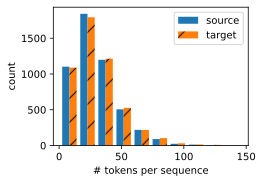

In [15]:
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', src[:5000], tgt[:5000])

10000 primeiras centenças do dataset:

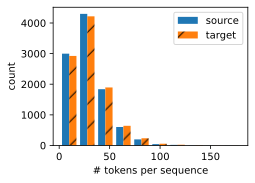

In [16]:
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', src[:10000], tgt[:10000])

## Criação dos arrays de mesmo tamanho

In [17]:
@d2l.add_to_class(EuroParlEnPt)
def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super(EuroParlEnPt, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
        self._download())

@d2l.add_to_class(EuroParlEnPt)
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = tf.constant([vocab[s] for s in sentences])
        valid_len = tf.reduce_sum(
            tf.cast(array != vocab['<pad>'], tf.int32), 1)
        return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text),
                              self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
            src_vocab, tgt_vocab)

In [18]:
@d2l.add_to_class(EuroParlEnPt)
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

In [19]:
data = EuroParlEnPt(batch_size=3)
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', tf.cast(src, tf.int32))
print('decoder input:', tf.cast(tgt, tf.int32))
print('source len excluding pad:', tf.cast(src_valid_len, tf.int32))
print('label:', tf.cast(label, tf.int32))

2025-02-17 19:52:34.629795: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-02-17 19:52:34.895586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [512,9]
	 [[{{node Placeholder/_3}}]]
2025-02-17 19:52:34.896446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [512,9]
	 [[{{node Placeholder/_1}}]]


source: tf.Tensor(
[[192 418 422 205  11   9 384   9   9]
 [376 410 126 441   9 428 401  21   3]
 [475 107 255  63 231 119   5   7   8]], shape=(3, 9), dtype=int32)
decoder input: tf.Tensor(
[[  8 108 437 485 448  11 142 386 370]
 [  8  12  11 114 487 189  11  11 305]
 [  8 455 291 256  68   6   9  10  10]], shape=(3, 9), dtype=int32)
source len excluding pad: tf.Tensor([9 9 8], shape=(3,), dtype=int32)
label: tf.Tensor(
[[108 437 485 448  11 142 386 370  18]
 [ 12  11 114 487 189  11  11 305 177]
 [455 291 256  68   6   9  10  10  10]], shape=(3, 9), dtype=int32)


In [20]:
@d2l.add_to_class(EuroParlEnPt)
def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
        raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

src, tgt, _,  _ = data.build(['mr president ladies and gentlemen'], ['senhor presidente senhoras e senhores'])
print('source:', data.src_vocab.to_tokens(tf.cast(src[0], tf.int32)))
print('target:', data.tgt_vocab.to_tokens(tf.cast(tgt[0], tf.int32)))

source: ['mr', 'president', 'ladies', 'and', 'gentlemen', '<eos>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'senhor', 'presidente', 'senhoras', 'e', 'senhores', '<eos>', '<pad>', '<pad>']


## Definição do Encoder

In [21]:
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)

    def call(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(tf.transpose(X))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

## Definição do Decoder

In [22]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def call(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(tf.transpose(X))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = tf.tile(tf.expand_dims(context, 0), (embs.shape[0], 1, 1))
        # Concat at the feature dimension
        embs_and_context = tf.concat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = tf.transpose(self.dense(outputs), (1, 0, 2))
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

## Definição do Encoder–Decoder

In [23]:
class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return tf.keras.optimizers.Adam(learning_rate=self.lr)

In [24]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = tf.cast(tf.reshape(Y, -1) != self.tgt_pad, tf.float32)
    return tf.reduce_sum(l * mask) / tf.reduce_sum(mask)

## Treinamento

### Atenção
**O erro na saída dessa célula é devido a interrupção manual da execução da mesma. Ou seja, o treinamento do modelo ocorreu conforme o gráfico do histórico do treinamento**

KeyboardInterrupt: 

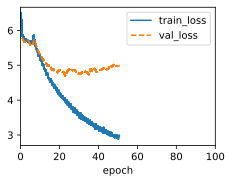

In [25]:
data = EuroParlEnPt(batch_size=128, num_steps=10, num_train=4096, num_val=512)
embed_size, num_hiddens, num_layers, dropout = 64, 128, 2, 0.5
with d2l.try_gpu():
    encoder = Seq2SeqEncoder(
        len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqDecoder(
        len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
    model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1)
print("Treinando")
trainer.fit(model, data)

> Após alguns testes, foi observado que, para os hiperparâmetros acima e outras configurações semelhantes, treinamentos realizados por menos de 30 épocas apresentaram resultados insatisfatórios (apresentado em seguida). Por isso, optamos por treinar o modelo por 100 épocas. O dropout teve que ser aumentado numa tentativa de reduzir o overfitting, entretanto, a partir da época 40, indícios de overfitting começaram a ser percebidos e, então, o treinamento foi interrompido manualmente..

> Foi utilizada uma quantidade pequena, também, de dados do dataset, para que o treinamento tomasse menos tempo diante dos recursos computacionais disponíveis, levando, naturalmente, a um modelo com um vocabulário mais limitado.

*Nota*: Parar o treinamento após 50 épocas se mostrou melhor que treinar por 100 épocas. Embora o resultado do treinamento mais longo tenha sido perdido, o modelo treinado por 50 épocas apresentou um desempenho melhor, como será visto a seguir

## Avaliação

In [26]:
@d2l.add_to_class(d2l.EncoderDecoder)
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len, training=False)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tf.expand_dims(tgt[:, 0], 1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state, training=False)
        outputs.append(tf.argmax(Y, 2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return tf.concat(outputs[1:], 1), attention_weights

In [32]:
engs = ['the european parliament .', 'mr . president .']
ports = ['o parlamento europeu .', 'senhor presidente .']
preds, _ = model.predict_step(
    data.build(engs, ports), d2l.try_gpu(), data.num_steps)
for en, pt, p in zip(engs, ports, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{sentence_bleu([translation], pt.split(), weights=(1, 0, 0, 0))}')

the european parliament . => ['está', 'encerrado', 'o', 'debate', '.'], bleu,0.38940039153570244
mr . president . => ['senhor', 'presidente', ',', 'a', 'notícia'], bleu,0.3422780793550613


In [ ]:
from nltk.translate.bleu_score import SmoothingFunction

engs = text_en[:2500]
ports = text_pt[:2500]
preds, _ = model.predict_step(
    data.build(engs, ports), d2l.try_gpu(), data.num_steps)

score = 0
i = 0
chencherry = SmoothingFunction()

for en, pt, p in zip(engs, ports, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    if (i < 10):
        print(pt, translation)
        
    i+=1
    score += sentence_bleu([translation], pt.split(), smoothing_function=chencherry.method1)

mean_BLEU = score / 10000

print('mean_score: ', mean_BLEU)

reinício da sessão ['(o', 'parlamento', 'aprova', 'a', 'resolução)']
declaro reaberta a sessão do parlamento europeu , que tinha sido interrompida na sexta-feira , 17 de dezembro último , e renovo todos os meus votos , esperando que tenham tido boas férias . ['presentemente', ',', 'o', 'parlamento', 'europeu', '<unk>', 'a', 'comissão', 'europeia', '.']
como puderam constatar , o grande "bug do ano 2000" não aconteceu . em contrapartida , os cidadãos de alguns dos nossos países foram vítimas de catástrofes naturais verdadeiramente terríveis . ['por', 'exemplo', ',', 'o', 'que', 'está', 'a', '<unk>', 'de', '<unk>']
os senhores manifestaram o desejo de se proceder a um debate sobre o assunto nos próximos dias , durante este período de sessões . ['por', 'outro', 'lado', ',', 'a', 'grande', '<unk>', 'de', '<unk>', 'com']
entretanto , gostaria - como também me foi pedido por um certo número de colegas - que observássemos um minuto de silêncio por todas as vítimas , nomeadamente das tempestad

A tradução das dez primeiras sentenças do dataset se mostrou insatisfatória, não sendo capaz de traduzir frases por completo e por vezes traduzindo palavras de maneira completamente incorreta.

Isso pode se dar pelo treinamento do modelo com poucas épocas e poucos dados, o que não foi suficiente para que o modelo aprendesse a traduzir as sentenças de forma satisfatória, bem como pela escolha de parâmetros inadequados, 

**E quanto a um treinamento mais curto?**

Para comparação, foi treinado o modelo, também, por 30 épocas:

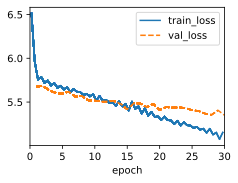

In [35]:
data_30 = EuroParlEnPt(batch_size=128, num_steps=10, num_train=4096, num_val=512)
embed_size_30, num_hiddens_30, num_layers_30, dropout_30 = 64, 128, 2, 0.5
with d2l.try_gpu():
    encoder_30 = Seq2SeqEncoder(
        len(data_30.src_vocab), embed_size_30, num_hiddens_30, num_layers_30, dropout_30)
    decoder_30 = Seq2SeqDecoder(
        len(data_30.tgt_vocab), embed_size_30, num_hiddens_30, num_layers_30, dropout_30)
    model = Seq2Seq(encoder_30, decoder_30, tgt_pad=data_30.tgt_vocab['<pad>'],
                    lr=0.005)
trainer_30 = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
print("Treinando")
trainer_30.fit(model, data_30)

In [38]:
engs = ['the european parliament .', 'mr . president .']
ports = ['o parlamento europeu .', 'senhor presidente .']
preds, _ = model.predict_step(
    data_30.build(engs, ports), d2l.try_gpu(), data_30.num_steps)
for en, pt, p in zip(engs, ports, preds):
    translation = []
    for token in data_30.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{sentence_bleu([translation], pt.split(), weights=(1, 0, 0, 0))}')

the european parliament . => ['a', 'comissão', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], bleu,0
mr . president . => ['senhor', 'presidente', ',', ',', ',', ',', ',', ',', ',', ','], bleu,0.06464797857627003


In [37]:
from nltk.translate.bleu_score import SmoothingFunction

engs = text_en[:2500]
ports = text_pt[:2500]
preds, _ = model.predict_step(
    data_30.build(engs, ports), d2l.try_gpu(), data_30.num_steps)

score = 0
i = 0
chencherry = SmoothingFunction()

for en, pt, p in zip(engs, ports, preds):
    translation = []
    for token in data_30.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    if (i < 10):
        print(pt, translation)
        
    i+=1
    score += sentence_bleu([translation], pt.split(), smoothing_function=chencherry.method1)

mean_BLEU = score / 10000

print('mean_score: ', mean_BLEU)

reinício da sessão ['a', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
declaro reaberta a sessão do parlamento europeu , que tinha sido interrompida na sexta-feira , 17 de dezembro último , e renovo todos os meus votos , esperando que tenham tido boas férias . ['a', 'comissão', ',', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
como puderam constatar , o grande "bug do ano 2000" não aconteceu . em contrapartida , os cidadãos de alguns dos nossos países foram vítimas de catástrofes naturais verdadeiramente terríveis . ['a', '<unk>', ',', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
os senhores manifestaram o desejo de se proceder a um debate sobre o assunto nos próximos dias , durante este período de sessões . ['<unk>', ',', ',', ',', ',', ',', ',', ',', ',', ',']
entretanto , gostaria - como também me foi pedido por um certo número de colegas - que observássemos um minuto de silêncio por todas as vítimas , nomeadamen

A pontuação média desse modelo foi inferior à do IBMModel1, além de que, aparentemente, observando as 10 primeiras sentenças traduzidas, o modelo não desenvolveu vocabulário suficiente para traduzir as sentenças de maneira satisfatória.

# Conclusão

Levando em consideração a o guia da documentação do Google Cloud para avaliação de modelos de tradução (https://cloud.google.com/translate/docs/advanced/automl-evaluate?hl=pt-br#:~:text=BLEU%20(BiLingual%20Evaluation%20Understudy)%20is,of%20high%20quality%20reference%20translations), o modelo codificador-decodificador apresentou uma pontuação BLEU de $0.7\%$, o que indica que a tradução é "Praticamente inútil". O modelo IBMModel1, de modo semelhante, apresentou uma pontuação BLEU média de $0.3\%$, o que indica que a tradução é, igualmente, "Praticamente inútil".

A pontuação baixa do modelo IBMModel1 se deve ao fato desse ser um modelo estatístico simples que não leva em consideração o contexto da sentença. Por outro lado, apesar de o modelo codificador-decodificador ser um modelo de aprendizado profundo que leva em consideração o contexto da sentença, a sua pontuação BLEU também foi baixa. Isso pode ser explicado pelo fato de que o modelo foi treinado com um dataset pequeno, não sendo suficiente para que o modelo aprendesse a traduzir as sentenças de forma satisfatória. Além disso, a escolha de parâmetros inadequados também pode ter contribuído para uma baixa pontuação BLEU, fazendo necessários ajustes para que o modelo apresente uma tradução mais precisa. A exemplo, o número de camadas `num_layer` maior poderia proporcionar um melhor desempenho na tarefa de traduzir o texto, porém, dado o poder computacional disponível para o treinamento, valores mais altos tornavam o procedimento muito custoso. Entretanto, o modelo codificador-decodificador apresentou uma pontuação BLEU ligeiramente maior que a do modelo IBMModel1, o que indica que o modelo codificador-decodificador pode ser mais eficiente que o modelo IBMModel1 para a tradução de sentenças quando treinado adequadamente.

Portanto, observada a pontuação bleu do modelo decoder-encoder para uma base tão limitada em termos de vocabulário, podemos especular que o modelo teria um desempenho melhor com um dataset maior e mais variado, bem como com mais épocas de treinamento e ajustes corretos dos hiperparâmetros.